Goal 

The goal of your project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

1-Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
2-We will pick 2 countries and see if there is a statistically significant difference in the discount amount given to customers in those 2 countries
3-We will also check if there is a statistically significant difference in the quantity of products sold by the employees of those two countries.
4-We will look into the performance of the employees in two different countries.

Importing the libraries

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as scs
from statsmodels.stats.power import tt_ind_solve_power
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Connecting to the database

In [2]:
#Connecting to the database
conn = sqlite3.connect('Northwind_small.sqlite')
cursor = conn.cursor()

In [3]:
#list of all tables
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]
tables

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [4]:
#Converting data into DataFrame
def get_table(conn=conn, table='Employee'):
    df = pd.read_sql(f'select * from {table}', conn)
    return df

Exploratory Data Analysis

In [5]:
OrderDetail_df = get_table(table='OrderDetail')
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [6]:
#Basic statistic
OrderDetail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


Base on the basic statistic above we have a total of 77 products. We will check to see how many are discounted and at which percentage.

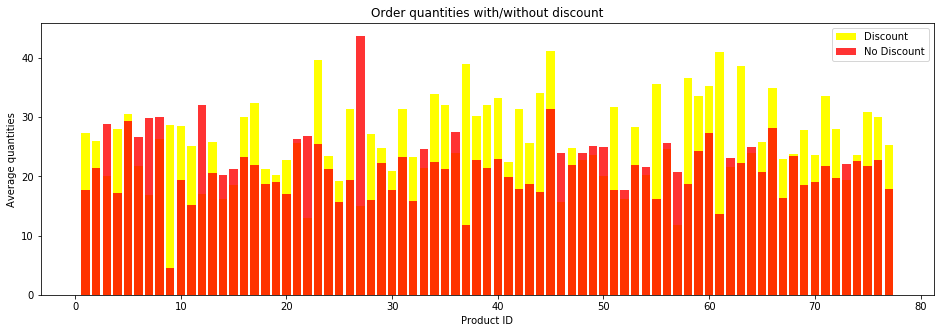

Conclusion
On average 70.0% of discounted products were sold in larger quantities
Average order quantity with discount - 26.43 items, without - 21.81 items


In [7]:
discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(16,5))
plt.bar(discount.index, discount.values, alpha=1, label='Discount', color='yellow')
plt.bar(no_discount.index, no_discount.values, alpha=0.8, label='No Discount', color='red')
plt.legend()
plt.title('Order quantities with/without discount')
plt.xlabel('Product ID')
plt.ylabel('Average quantities')
plt.show()
print('Conclusion')
print("On average {}% of discounted products were sold in larger quantities".format(round(sum(discount.values > no_discount.values)/len(discount.values)*100),2))
print("Average order quantity with discount - {} items, without - {} items".format(round(discount.values.mean(),2), round(no_discount.values.mean(),2)))

It is clear above that items sold with discounted prices were sold in larger quantities. Can we statistically prove this hypothesis.

In [8]:
#Determination of the level of discount
discounts = OrderDetail_df['Discount'].unique()
discounts.sort()
print('Discount levels')
print(discounts)

Discount levels
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


In [9]:
#Number of orders per discount level
groups = {}
for d in discounts:
    groups[d] = OrderDetail_df[OrderDetail_df['Discount']==d]

In [10]:
# DataFrame with the discount level in percentage, Orders and average order quantity.
discounts_df = pd.DataFrame(columns=['Discount %','Orders','Avg. Order Quantity'])
for i in groups.keys():
    discounts_df = discounts_df.append({'Discount %':i*100,'Orders':len(groups[i]),'Avg. Order Quantity':groups[i]['Quantity'].mean()}, ignore_index=True)
discounts_df

,Discount %,Orders,Avg. Order Quantity
0,0.0,1317.0,21.715262
1,1.0,1.0,2.000000
2,2.0,2.0,2.000000
3,3.0,3.0,1.666667
4,4.0,1.0,1.000000
5,5.0,185.0,28.010811
6,6.0,1.0,2.000000
7,10.0,173.0,25.236994
8,15.0,157.0,28.382166
9,20.0,161.0,27.024845


Base on the table above, discount of 1%, 2%, 3%, 4% and 6% have a relatively low average order quantities, they appears as outliers and we we can proceed without them in our experiment.

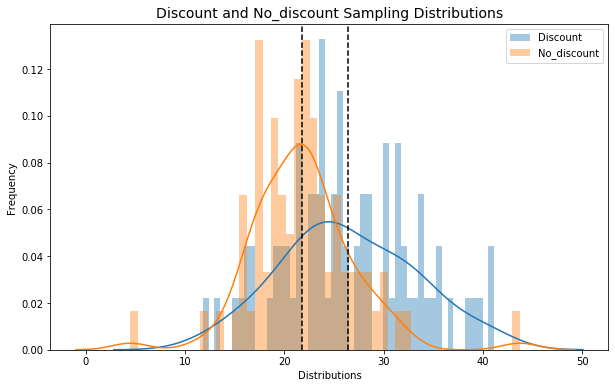

In [11]:
#visualization of Discount and No_discount
plt.figure(figsize=(10,6))
sns.distplot(discount, bins=50, label='Discount')
sns.distplot(no_discount, bins=50, label='No_discount')
plt.axvline(x=no_discount.mean(), color='black', linestyle='--')
plt.axvline(x=discount.mean(), color='black', linestyle='--')
plt.title('Discount and No_discount Sampling Distributions', fontsize=14)
plt.xlabel('Distributions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

There are some differences between the mean and standard deviation of no_discount and discount groups. This is a good sign to further our experimentation and to calculate whether the difference is significant, or not.To do that we will Set up null and alternative hypotheses,  choose a significance level, calculate the test statistic, determine the critical or pvalue (find the rejection region), compare t-value with critical t-value to reject or fail to reject the null hypothesis

we will answer the first question using the raw data without any test of normallity, we will then draw some random sample to further infirm or confirm our hypothesis.

Null hypothesis H0: the discount do not have any influence on the quantity of order

Alternate hypothesis Ha: the quantity ordered increase when discount are applied.

We will use Cohen'd statistic and pvalue to reject or accept our hypothesis.Let set our alpha value at 0.025. 
if pvalue < 0.025, we will reject the null hypothesis.

In [12]:
#Function that will help determine cohen'd value
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
# Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
# Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [13]:
st, p = scs.ttest_ind(discount, no_discount)
d = Cohen_d(discount, no_discount)
p, d

(4.653938937192578e-06, 0.7656454596347829)

P < 0.025 and d ~ 0.76, The null hypothesis is rejected, at least 76% of the orders with discount have large quantities. we can conclude that: discount amount have a statistically significant effect on the quantity of a product in an order.

Let us specifically test our hypothesis at each discount level by determining p and d at that level.

In [14]:
discounts_significance_df = pd.DataFrame(columns=['Discount %','p','Cohens d'], index=
None)
discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
for i in discounts:
    discount = OrderDetail_df[OrderDetail_df['Discount']==i]['Quantity']
    st, p = scs.ttest_ind(no_discount, discount)
    d = Cohen_d(no_discount, discount)
    discounts_significance_df = discounts_significance_df.append( { 'Discount %' : str(i*100)+'%' , 'p': p , 'Cohens d' : d } , ignore_index=True)
discounts_significance_df

,Discount %,p,Cohens d
0,5.0%,0.000011,0.346877
1,10.0%,0.015501,0.195942
2,15.0%,0.000011,0.372404
3,20.0%,0.000326,0.300712
4,25.0%,0.000018,0.366593


The table above is indicating that at each level of discount, discount amount have a statistically significant effect on the quantity of a product in an order.

Now is time to answer our question 2, we will choose two random countries in the table and  see if the discount given to customers by employees in one country is statistically different from the discount in the other country. Let us see the countries of the employees

In [15]:
customer_df = get_table(table='Employee' )
customer_df

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp
5,6,Suyama,Michael,Sales Representative,Mr.,1995-07-02,2025-10-17,Coventry House Miner Rd.,London,British Isles,EC2 7JR,UK,(71) 555-7773,428,None,Michael is a graduate of Sussex University (MA...,5.0,http://accweb/emmployees/davolio.bmp
6,7,King,Robert,Sales Representative,Mr.,1992-05-29,2026-01-02,Edgeham Hollow Winchester Way,London,British Isles,RG1 9SP,UK,(71) 555-5598,465,None,Robert King served in the Peace Corps and trav...,5.0,http://accweb/emmployees/davolio.bmp
7,8,Callahan,Laura,Inside Sales Coordinator,Ms.,1990-01-09,2026-03-05,4726 - 11th Ave. N.E.,Seattle,North America,98105,USA,(206) 555-1189,2344,None,Laura received a BA in psychology from the Uni...,2.0,http://accweb/emmployees/davolio.bmp
8,9,Dodsworth,Anne,Sales Representative,Ms.,1998-01-27,2026-11-15,7 Houndstooth Rd.,London,British Isles,WG2 7LT,UK,(71) 555-4444,452,None,Anne has a BA degree in English from St. Lawre...,5.0,http://accweb/emmployees/davolio.bmp


As seen in the DataFrame above all the employees are located in two countries only: USA and UK.

In [16]:
#Table of discount by country
discount_usa_vs_uk = pd.read_sql_query('''
SELECT OD.Discount, OD.Quantity, E.Country FROM [Order] AS O
JOIN OrderDetail AS OD ON O.Id = OD.OrderId
JOIN Employee AS E ON O.EmployeeId = E.Id
WHERE COUNTRY ='USA' ''', conn)
discount_usa_vs_uk.head()

,Discount,Quantity,Country
0,0.00,10,USA
1,0.15,35,USA
2,0.15,15,USA
3,0.05,6,USA
4,0.05,15,USA


In [17]:
# Dropping the NaN
discount_usa_vs_uk.dropna(inplace=True)

We will use ANOVA here to see if the discount given by employee in the UK is statistically different from the discount given by employee in the USA. We will verify the result using Cohen'd.

H0: There is no significant difference between the discounts given by employees from the USA versus the employees from UK.

Ha: There is a significant difference between the discounts given by employees from the USA versus the employees from UK.

In [18]:
#ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
formula = 'Country ~C(Discount)'
lm = ols(formula, discount_usa_vs_uk).fit()
table = sm.stats.anova_lm(lm, type=2)
print(table)

                 df        sum_sq       mean_sq          F        PR(>F)
C(Discount)    10.0  3.906090e-27  3.906090e-28  38.344719  7.241464e-68
Residual     1576.0  1.605435e-26  1.018677e-29        NaN           NaN


Keeping in mind that our data is not normal, ANOVA may not be accurate to use here. We will give an interpretation of the result. Result of ANOVA Test shows that there is statistically significant difference in  discount given by employee in USA vs UK.
We will verify this result using Cohen'd

In [19]:
#Order placed by employees in USA
discount_usa = pd.read_sql_query('''
SELECT OD.Discount, OD.Quantity, OD.UnitPrice, OD.ProductId, E.Country, O.EmployeeId FROM [Order] AS O
JOIN OrderDetail AS OD ON O.Id = OD.OrderId
JOIN Employee AS E ON O.EmployeeId = E.Id
WHERE Country ='USA' ''', conn)
discount_usa.head()

,Discount,Quantity,UnitPrice,ProductId,Country,EmployeeId
0,0.00,10,7.7,41,USA,4
1,0.15,35,42.4,51,USA,4
2,0.15,15,16.8,65,USA,4
3,0.05,6,16.8,22,USA,3
4,0.05,15,15.6,57,USA,3


In [20]:
#Order placed by employees in UK
discount_uk = pd.read_sql_query('''
SELECT OD.Discount, OD.Quantity, OD.UnitPrice, OD.ProductId, E.Country, O.EmployeeId FROM [Order] AS O
JOIN OrderDetail AS OD ON O.Id = OD.OrderId
JOIN Employee AS E ON O.EmployeeId = E.Id
WHERE Country ='UK' ''', conn)
discount_uk.head()

,Discount,Quantity,UnitPrice,ProductId,Country,EmployeeId
0,0.0,12,14.0,11,UK,5
1,0.0,10,9.8,42,UK,5
2,0.0,5,34.8,72,UK,5
3,0.0,9,18.6,14,UK,6
4,0.0,40,42.4,51,UK,6


In [21]:
#Discount given by employees in USA
dusa = discount_usa[discount_usa['Discount']!=0].groupby('ProductId')['Quantity'].mean()

In [22]:
#Discount given by employees in UK
duk = discount_uk[discount_uk['Discount']!=0].groupby('ProductId')['Quantity'].mean()

In [23]:
#Cohen'd and pvalue
st, p = scs.ttest_ind(dusa, duk)
d = Cohen_d(dusa, duk)
p, d

(0.3209485285793383, 0.16210308126999937)

As we can see above, we have a pvalue > 0.025 and d < 0.2: these two results are making our null hypothesis true: There is no significant difference between the discounts given by employees from the USA versus the employees from UK.
We are running into a contradiction at this point; the results will probably be different if we have a normal distribution. Let us visualize these results below. 

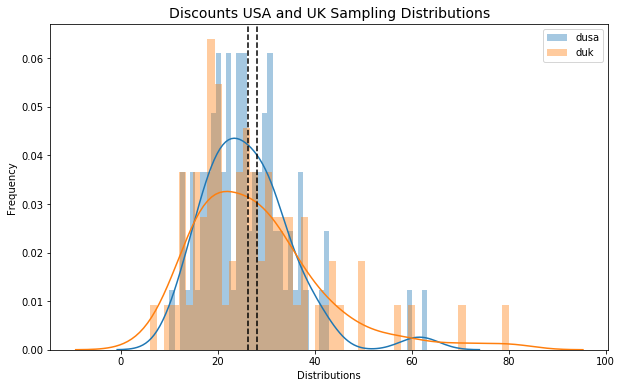

In [24]:
#Visualization the discounts by employee from USA and UK.
plt.figure(figsize=(10,6))
sns.distplot(dusa, bins=50, label='dusa')
sns.distplot(duk, bins=50, label='duk')
plt.axvline(x=dusa.mean(), color='black', linestyle='--')
plt.axvline(x=duk.mean(), color='black', linestyle='--')
plt.title('Discounts USA and UK Sampling Distributions', fontsize=14)
plt.xlabel('Distributions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Base on the graph above, the employees in the USA are given more discounts but, the densities probabilities have about the same mean, on average, the discounts given by employees from the USA is not statistically different from the discounts given by employees from the UK.
We will now answer our third question,is there a is there a statistically significant difference between the quantity of product sold in the USA versus the UK? Our hypothesis:

H0: there is no statistically significant difference between the quantity of product sold in the USA versus the UK.

Ha: there is a statistically significant difference between the quantity of product sold in the USA versus the UK.

We will use cohen'd

In [25]:
#Quantity of product sold by employees in USA
qusa = discount_usa[discount_usa['Quantity']!=0].groupby('ProductId')['EmployeeId'].mean()

In [26]:
#Quantity of product sold by employees in UK
quk = discount_uk[discount_uk['Quantity']!=0].groupby('ProductId')['EmployeeId'].mean()

In [27]:
#Cohen'd and pvalue
st, p = scs.ttest_ind(quk, qusa)
d = Cohen_d(quk, qusa)
p, d

(6.836883819635204e-68, 5.060370336314389)

The pvalue = 6.836883819635204e-68 < 0.025 and d=5.06 > 0.2, our null hypothesis is rejected and there is a statistically significant difference between the quantity of product sold in the USA versus the UK.Now let us see if base on the fact that the quantities of products sold by employees in these two countries are different, the processing times may be different from one country to another. To do that we will have to convert order dates and shipped dates into time and determine the processing time. Our hypothesises in this case are:

H0: there is no statistically significant difference between the processing time per order in the USA versus the UK.

Ha: there is a statistically significant difference between the processing time per order in the USA versus the UK.

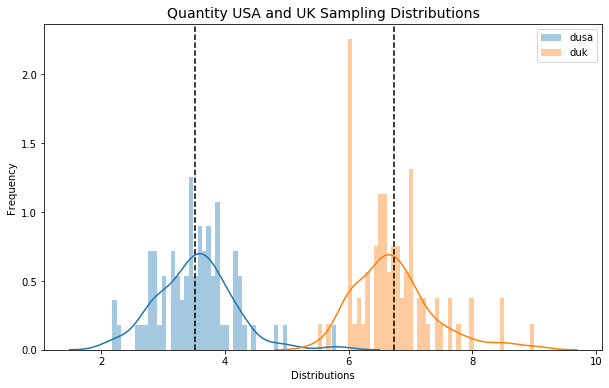

In [28]:
#Visualizing the quantity of products per employee in both USA and UK.
plt.figure(figsize=(10,6))
sns.distplot(qusa, bins=50, label='dusa')
sns.distplot(quk, bins=50, label='duk')
plt.axvline(x=qusa.mean(), color='black', linestyle='--')
plt.axvline(x=quk.mean(), color='black', linestyle='--')
plt.title('Quantity USA and UK Sampling Distributions', fontsize=14)
plt.xlabel('Distributions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [29]:
order_and_shipped_date = pd.read_sql_query('''
SELECT O.Id, O.OrderDate, O.ShippedDate, E.Country FROM [Order] AS O
JOIN Employee AS E
ON O.EmployeeId = E.Id
''',conn)
order_and_shipped_date.head()

,Id,OrderDate,ShippedDate,Country
0,10248,2012-07-04,2012-07-16,UK
1,10249,2012-07-05,2012-07-10,UK
2,10250,2012-07-08,2012-07-12,USA
3,10251,2012-07-08,2012-07-15,USA
4,10252,2012-07-09,2012-07-11,USA


In [39]:
#Converting dates into time and determining the processing times.
order_and_shipped_date['OrderDate'] = pd.to_datetime(order_and_shipped_date.OrderDate)
order_and_shipped_date['ShippedDate'] = pd.to_datetime(order_and_shipped_date.ShippedDate)
order_and_shipped_date['ProcessingTime'] = abs(order_and_shipped_date['ShippedDate']-order_and_shipped_date['OrderDate'])
order_and_shipped_date['ProcessingTime'] = order_and_shipped_date.ProcessingTime.dt.days

In [40]:
order_and_shipped_date.head()

,Id,OrderDate,ShippedDate,Country,ProcessingTime
0,10248,2012-07-04,2012-07-16,UK,12
1,10249,2012-07-05,2012-07-10,UK,5
2,10250,2012-07-08,2012-07-12,USA,4
3,10251,2012-07-08,2012-07-15,USA,7
4,10252,2012-07-09,2012-07-11,USA,2


In [41]:
# Processing times in USA and UK
tusa = order_and_shipped_date[order_and_shipped_date.Country == 'USA']['ProcessingTime']
tuk = order_and_shipped_date[order_and_shipped_date.Country == 'UK']['ProcessingTime']

In [42]:
#Determining the average processing time per employee in USA
tusa_mean = order_and_shipped_date[order_and_shipped_date.Country == 'USA']['ProcessingTime'].mean()
tusa_mean

8.375634517766498

In [43]:
order_and_shipped_date.dropna(inplace=True)

In [44]:
#Determining the average processing time per employee in UK
tuk_mean = order_and_shipped_date[order_and_shipped_date.Country == 'UK']['ProcessingTime'].mean()
tuk_mean

8.807339449541285

In [45]:
#Cohen'd and pvalue
st, p = scs.ttest_ind(tusa, tuk)
d = Cohen_d(tusa, tuk)
p, d

(0.42599888071882475, 0.06310985453186797)

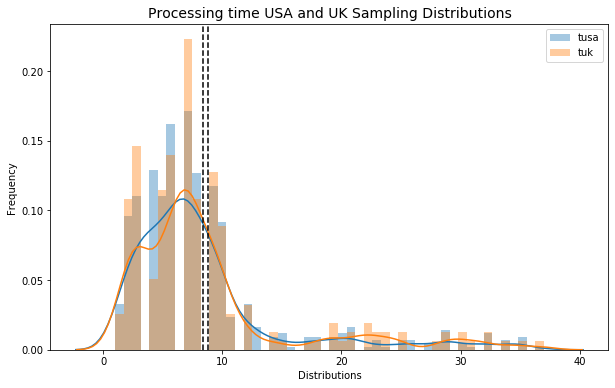

In [46]:
#Visualizing the processing time per employee in both USA and UK.
plt.figure(figsize=(10,6))
sns.distplot(tusa, bins=50, label='tusa')
sns.distplot(tuk, bins=50, label='tuk')
plt.axvline(x=tusa.mean(), color='black', linestyle='--')
plt.axvline(x=tuk.mean(), color='black', linestyle='--')
plt.title('Processing time USA and UK Sampling Distributions', fontsize=14)
plt.xlabel('Distributions')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The pvalue = 0.42 > 0.025 and d=0.06 < 0.2, our null hypothesis is not rejected and there is no statistically significant difference between the processing time per order in the USA versus the UK. The means of the processing times in both country is showing a slight advantage to USA(lower processing time per employee). We can conclude that the employees in the USA are slightly more performant than the employees in UK.